### Account Relation Data Preprocessing

In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

def transform_df_with_date(df, columnName, newColumnName):
  df[columnName] = df[columnName].apply(normalize_date)
  df.rename(columns={columnName: newColumnName}, inplace = True)

def normalize_date(accountDate):
  dateObj = datetime.strptime(str(accountDate), '%y%m%d')
  return relativedelta(datetime.now(), dateObj).years

account_data = pd.read_csv("./files/account.csv", sep=";", index_col=0)
transform_df_with_date(account_data, "date", "years_since_acc_open")
account_data.to_csv("./preprocessed/account.csv")

### Client Relation Data Preprocessing

Text(0.5, 1.0, 'Distribution of Client Ages')

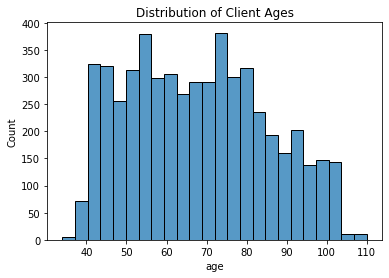

In [2]:
import re
import seaborn as sb
from sklearn.preprocessing import KBinsDiscretizer

client_data = pd.read_csv("./files/client.csv", sep=";", index_col=0)

clientGenders = []
clientAge = []

def normalize_birthNumber(clientBirthNumber):
  dateSearch = re.search('(\d{2})(\d{2})(\d{2})', str(clientBirthNumber))
  years = int(dateSearch.group(1))
  months = int(dateSearch.group(2))
  days = int(dateSearch.group(3))
  
  gender = "M"
  if months > 12:
    gender = "F"
    months = months - 50

  dateObj = datetime.strptime(f"19{years}-{months}-{days}", '%Y-%m-%d')
  age = relativedelta(datetime.now(), dateObj).years

  clientGenders.append(gender)
  clientAge.append(age)


client_data.birth_number = client_data.birth_number.apply(normalize_birthNumber)
client_data['gender'] = clientGenders
client_data['age'] = clientAge

sb.histplot(data=client_data, x="age",).set_title("Distribution of Client Ages")

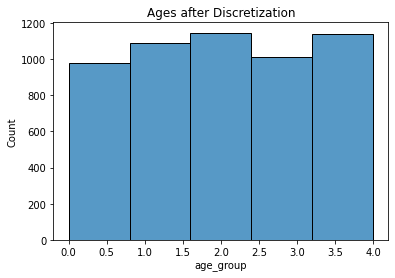

In [3]:
# Equal-Frequency Discretization
client_age_data = client_data['age'].values.reshape(-1,1)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
client_data['age_group'] = discretizer.fit_transform(client_age_data)

sb.histplot(data=client_data['age_group'], bins=5).set_title("Ages after Discretization")

client_data.drop(columns = ['birth_number', 'age'], inplace = True)
client_data.to_csv("./preprocessed/client.csv")

### Card Relation Data Preprocessing

In [4]:
card_test_data = pd.read_csv("./files/card_test.csv", sep=";", index_col=0)
card_train_data = pd.read_csv("./files/card_train.csv", sep=";", index_col=0)

transform_df_with_date(card_test_data, "issued", "years_since_issued")
transform_df_with_date(card_train_data, "issued", "years_since_issued")

card_test_data.to_csv("./preprocessed/card_test.csv")
card_train_data.to_csv("./preprocessed/card_train.csv")   

### Loan Relation Data Preprocessing

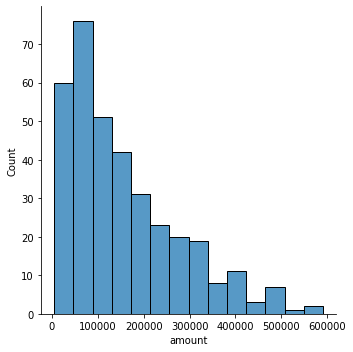

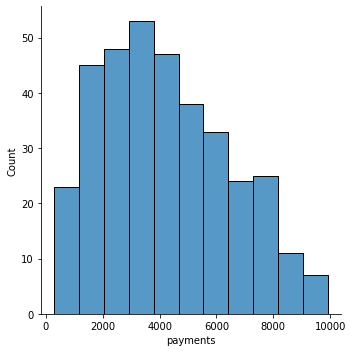

In [5]:
def plot_distribution(df, column_name):
    sb.displot(df, x=column_name)

loan_test_data = pd.read_csv("./files/loan_test.csv", sep=";")
loan_train_data = pd.read_csv("./files/loan_train.csv", sep=";")

transform_df_with_date(loan_test_data, "date", "years_since_loan")

plot_distribution(loan_test_data, "amount")
plot_distribution(loan_test_data, "payments")

loan_test_data.to_csv("./preprocessed/loan_test_data.csv")
loan_train_data.to_csv("./preprocessed/loan_train_data.csv")

# TO DO
# Categorizar "amount" e "payments"

### Transational Relation Data Preprocessing

In [6]:
import numpy as np

def stdDeviation_trans_data(df):
  test_df = df.sort_values(by=['account_id'])
  test_df = test_df.groupby(['account_id']).first()
  
  # Get different account_ids
  account_ids = test_df.index
  itr_per_account = []

  # Compute Standard Deviation for every account_id
  for account_id in account_ids:
    q3, q1 = np.percentile(df.loc[lambda df: df['account_id'] == account_id]['balance'], [75 ,25])
    itr_per_account.append(q3 - q1)

  return itr_per_account


def preprocess_transaction(df):
  itr_per_account = stdDeviation_trans_data(df)

  # Types of withdrawal in cash = withdrawal
  df.loc[df["type"] == "withdrawal in cash", "type"] = "withdrawal"

  # Withdrawals have negative balance
  df.loc[df["type"] == "withdrawal", "amount"] *= -1

  # Null Operation values are equivalent to Interest Credited as in k_symbol
  df["operation"].fillna('IC', inplace=True)

  # Renaming operations
  df.loc[df["operation"] == "collection from another bank", "operation"] = "CAB"
  df.loc[df["operation"] == "remittance to another bank", "operation"] = "RAB"
  df.loc[df["operation"] == "withdrawal in cash", "operation"] = "WC"
  df.loc[df["operation"] == "credit card withdrawal", "operation"] = "CCW"
  df.loc[df["operation"] == "credit in cash", "operation"] = "CC"
  
  first = lambda df: df.iloc[0]
  last = lambda df: df.iloc[-1]

  # Handling Transaction balances
  agg_balance = df.sort_values(by=['account_id', 'date'], ascending=[True, False]) \
                    .groupby(['account_id']) \
                    .agg({
                        'balance': ['mean', 'max', 'min', 'std', first, last],
                        'date': first,
                        'amount': first
                    }) \
                    .reset_index()
  
  agg_balance.columns = ['account_id', 'balance_mean', 'balance_max', 'balance_min', 'balance_std',
                          'last_balance', 'first_balance', 'last_trans_date', 'last_trans_amount']
  
  # Feature reached_negative_balance
  agg_balance['reached_negative_balance'] = agg_balance['balance_min']
  agg_balance.loc[agg_balance["balance_min"] >= 0, "reached_negative_balance"] = 1
  agg_balance.loc[agg_balance["balance_min"] < 0, "reached_negative_balance"] = -1

  # Handlign credits and withdrawals
  agg_types = df.sort_values(by=['account_id'], ascending=[True]) \
                            .groupby(['account_id', 'type']) \
                            .agg({
                                'amount': ['mean', 'count', 'max', 'min', 'std'],
                            }) \
                            .reset_index()

  agg_types.columns = ['account_id', 'type', 'type_mean', 'type_count', 'type_max', 'type_min', 'type_std']
  
  print(agg_types)

  agg_credits = agg_types[agg_types['type'] == 'credit']
  agg_credits.columns = ['account_id', 'type', 'credit_mean', 'credit_count', 'credit_max', 'credit_min', 'credit_std']
  agg_credits.drop(['type'], axis=1)
  
  agg_withdrawals = agg_types[agg_types['type'] == 'withdrawal']
  agg_withdrawals.columns = ['account_id', 'type', 'withdrawal_mean', 'withdrawal_count', 'withdrawal_max', 'withdrawal_min', 'withdrawal_std']
  agg_withdrawals.drop(['type'], axis=1)

  # Merging aggregated datasets - balance, credits and withdrawals
  agg_df = agg_balance.merge(agg_credits, on='account_id', how='left').merge(agg_withdrawals, on='account_id', how='left')

  # Clean missing values
  agg_df.fillna(0, inplace=True)

  # Cleaning nulls and performing aggreggation on table containing operations
  operations = df.groupby(['account_id', 'operation']) \
                          .agg({
                              'amount': ['count', 'mean', 'sum', 'max', 'std', 'min'],
                          }) \
                          .reset_index()

  operations.columns = ['account_id', 'operation', 'amount_count', 'amount_mean', 'amount_sum', 'amount_max', 'amount_std', 'amount_min']
  
  # IC
  ic = operations[operations['operation'] == 'IC']
  ic.columns = ['account_id', 'operation', 'IC', 'IC_mean', 'IC_sum', 'IC_max', 'IC_std', 'IC_min']
  ic = ic.drop(['operation'], axis=1)

  # CC
  cc = operations[operations['operation'] == 'CC']
  cc.columns = ['account_id', 'operation', 'CC', 'CC_mean', 'CC_sum', 'CC_max', 'CC_std', 'CC_min']
  cc = cc.drop(['operation'], axis=1)
  
  # CAB
  cab = operations[operations['operation'] == 'CAB']
  cab.columns = ['account_id', 'operation', 'CAB', 'CAB_mean', 'CAB_sum', 'CAB_max', 'CAB_std', 'CAB_min']
  cab =cab.drop(['operation'], axis=1)
  
  # WC
  wc = operations[operations['operation'] == 'WC']
  wc.columns = ['account_id', 'operation', 'WC', 'WC_mean', 'WC_sum', 'WC_max', 'WC_std', 'WC_min']
  wc = wc.drop(['operation'], axis=1)
  
  # RAB
  rab = operations[operations['operation'] == 'RAB']
  rab.columns = ['account_id', 'operation', 'RAB', 'RAB_mean', 'RAB_sum', 'RAB_max', 'RAB_std', 'RAB_min']
  rab = rab.drop(['operation'], axis=1)
  
  # CCW
  ccw = operations[operations['operation'] == 'CCW']
  ccw.columns = ['account_id', 'operation', 'CCW', 'CCW_mean', 'CCW_sum', 'CCW_max', 'CCW_std', 'CCW_min']
  ccw = ccw.drop(['operation'], axis=1)
  
  # Joining all the operations
  operations_df = cc.merge(cab, on='account_id', how='left') \
                    .merge(ic, on='account_id', how='left') \
                    .merge(wc, on='account_id', how='left') \
                    .merge(rab, on='account_id', how='left') \
                    .merge(ccw, on='account_id', how='left')
  
  # Clean missing values
  operations_df.fillna(0, inplace=True)

  # Mergind balance, types & operations
  new_df = agg_df.merge(operations_df, on='account_id', how='left')

  # Preprocess date to years since transaction
  transform_df_with_date(new_df, "last_trans_date", "years_since_transaction")

  # Adding extra columns
  new_df['total_ops'] = new_df['CC'] + new_df['CAB'] + new_df['WC'] + new_df['RAB'] + new_df['CCW'] + new_df['IC']
  new_df['credit_ratio'] = new_df['credit_count'] / new_df['total_ops']
  new_df['withdrawal_ratio'] = new_df['withdrawal_count'] / new_df['total_ops']
  new_df['mean_trans_profit'] = new_df['credit_mean'] + new_df['withdrawal_mean']
  new_df['itr_balance_per_account'] = itr_per_account
  new_df['balance_range'] = new_df['balance_max'] - new_df['balance_min']
  new_df['last_first_balance_ratio'] = new_df['last_balance'] / new_df['first_balance']
  new_df['last_max_balance_ratio'] = new_df['last_balance'] / new_df['balance_max']

  # OPs as ratios
  new_df['ratio_IC'] = new_df['IC'] / new_df['total_ops']
  new_df['ratio_CC'] = new_df['CC'] / new_df['total_ops']
  new_df['ratio_CAB'] = new_df['CAB'] / new_df['total_ops']
  new_df['ratio_WC'] = new_df['WC'] / new_df['total_ops']
  new_df['ratio_RAB'] = new_df['RAB'] / new_df['total_ops']
  new_df['ratio_CCW'] = new_df['CCW'] / new_df['total_ops']

  return new_df
# plot_distribution(trans_test_data, "balance")

trans_test_data = pd.read_csv("./files/trans_test.csv", sep=";", index_col=0)
trans_train_data = pd.read_csv("./files/trans_train.csv", sep=";", index_col=0)

trans_train_data = preprocess_transaction(trans_train_data)
trans_test_data = preprocess_transaction(trans_test_data)

trans_test_data.to_csv("./preprocessed/trans_test_data.csv")  
trans_train_data.to_csv("./preprocessed/trans_train_data.csv") 

/home/dukes/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


      account_id        type     type_mean  type_count  type_max  type_min  \
0              1      credit   1992.602000          50   12600.0      19.2   
1              1  withdrawal  -1380.479365          63     -14.6   -7500.0   
2              2      credit  10394.786364          22   30354.0      13.5   
3              2  withdrawal  -6276.393750          32     -14.6  -22400.0   
4              4      credit   3348.264706          17    5553.0      66.6   
...          ...         ...           ...         ...       ...       ...   
6459       11359  withdrawal  -6149.507843         102     -14.6  -30100.0   
6460       11362      credit   8811.758621          29   24212.0      50.1   
6461       11362  withdrawal  -2965.915385          78     -14.6  -16100.0   
6462       11382      credit  11086.665306          49   46248.0      36.3   
6463       11382  withdrawal -10324.820000          50      -1.0  -36000.0   

          type_std  
0      2298.080022  
1      1463.225675  


### District Relation Data Preprocessing
- Compute the average variation of North Moravia region regarding the unemployment rate in 95' and 96' and use it to substitute the "?" in "unemployment rate '95" column.
- Compute the average variation of North Moravia region regarding the number of commited crimes in 95' and 96' and use it to substitute the "?" in "no. of commited crimes '95" column.
- Sum and computed average of "unemploymant rate '95" e "unemploymant rate '96" columns and create new unemployment_rate column.
- Sum and computed average of "no. of commited crimes '95" e "no. of commited crimes '96" columns and create new no. of commited crimes column.
- Sum "no. of municipalities with inhabitants 500-1999" with "no. of municipalities with inhabitants 2000-9999" and create "no. of municipalities with inhabitants > 2000" column.
- Remove name column.

In [7]:
district_data = pd.read_csv("./files/district.csv", index_col=None)
validDistrictData = district_data.loc[lambda df: (df["unemploymant rate '95 "] != "?") & (df["no. of commited crimes '95 "] != "?")] # The region where the "?" is located.

def avgVariationNMoravia(first_col, second_col):
  validDistrictData[first_col] = pd.to_numeric(validDistrictData[first_col])
  validDistrictData[second_col] = pd.to_numeric(validDistrictData[second_col])
  variationAll = np.subtract(validDistrictData[second_col], validDistrictData[first_col])

  return np.array([-y / x for x, y in zip(validDistrictData[second_col], variationAll)]).mean()

avgUnemploymentVariation = avgVariationNMoravia("unemploymant rate '95 ", "unemploymant rate '96 ")
avgCommitedCrimesVariation = avgVariationNMoravia("no. of commited crimes '95 ", "no. of commited crimes '96 ")

# Calculate "?" value in columns "unemploymant rate '95" and "no. of commited crimes '95"
knownUnemployment96 = district_data.loc[lambda df: df["unemploymant rate '95 "] == "?"]["unemploymant rate '96 "].item()
newUnemployment95 = (knownUnemployment96 + (knownUnemployment96 * avgUnemploymentVariation))
knownCommitedCrime96 = district_data.loc[lambda df: df["no. of commited crimes '95 "] == "?"]["no. of commited crimes '96 "].item()
newCommitedCrime95 = int(knownCommitedCrime96 + (knownCommitedCrime96 * avgCommitedCrimesVariation))

def replaceMissingVal(district_data, col, newValue):
  district_data[col].replace({"?": newValue}, inplace=True)

  return district_data

district_data = replaceMissingVal(district_data, "unemploymant rate '95 ", newUnemployment95)
district_data = replaceMissingVal(district_data, "no. of commited crimes '95 ", newCommitedCrime95)

# Convertion of columns to int/float:
district_data['unemploymant rate \'95 '] = district_data['unemploymant rate \'95 '].astype(float)
district_data['unemploymant rate \'96 '] = district_data['unemploymant rate \'96 '].astype(float)
district_data['no. of commited crimes \'95 '] = pd.to_numeric(district_data['no. of commited crimes \'95 '])
district_data['no. of commited crimes \'96 '] = pd.to_numeric(district_data['no. of commited crimes \'96 '])
district_data['ratio of urban inhabitants '] = district_data['ratio of urban inhabitants '].astype(float)
district_data['no. of enterpreneurs per 1000 inhabitants '] = pd.to_numeric(district_data['no. of enterpreneurs per 1000 inhabitants '])

# Creating new features:
district_data['ratio entrepeneurs'] = district_data['no. of enterpreneurs per 1000 inhabitants '] / 1000
district_data['criminality_growth'] = (district_data['no. of commited crimes \'96 '] - district_data['no. of commited crimes \'95 ']) /\
                                       district_data['no. of inhabitants']
district_data['unemploymant_growth'] = district_data['unemploymant rate \'96 '] - district_data['unemploymant rate \'95 ']
    
district_data["no. of municipalities with inhabitants 500-1999"] = pd.to_numeric(district_data["no. of municipalities with inhabitants 500-1999"])
district_data["no. of municipalities with inhabitants 2000-9999 "] = pd.to_numeric(district_data["no. of municipalities with inhabitants 2000-9999 "])
district_data["no. of municipalities with inhabitants > 2000"] = np.add(district_data["no. of municipalities with inhabitants 500-1999"], district_data["no. of municipalities with inhabitants 2000-9999 "])

district_data.drop(columns = [
    "unemploymant rate '95 ",
    "unemploymant rate '96 ",
    "no. of municipalities with inhabitants 2000-9999 ",
    "no. of municipalities with inhabitants >10000 ",
    "no. of commited crimes '95 ",
    "no. of commited crimes '96 ",
    "name"
], inplace = True)

district_data.to_csv("./preprocessed/district.csv")

/tmp/ipykernel_14000/3968718439.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validDistrictData[first_col] = pd.to_numeric(validDistrictData[first_col])
/tmp/ipykernel_14000/3968718439.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validDistrictData[second_col] = pd.to_numeric(validDistrictData[second_col])


# Merging datasets
Merge all datasets and then compute train and test datasets. Funny fact: the loan_train is smaller than the loan_test.

### **TO DO: REFACTOR**

In [8]:
# Train Data
merged_data_train = pd.merge(loan_train_data, trans_train_data, on="account_id")
merged_data_train = pd.merge(merged_data_train, account_data, on="account_id")

#district_data = pd.read_csv("./files/district.csv", index_col=None)
district_data.rename(columns={"code": "district_id"}, inplace=True)
merged_data_train = pd.merge(merged_data_train, district_data, how="left", on="district_id")

disp_data = pd.read_csv("./files/disp.csv", sep=";")
merged_data_train = pd.merge(merged_data_train, disp_data, on="account_id")

# Remove rows with DISPONENT clients (because only owners can ask for a loan)
merged_data_train = merged_data_train.loc[lambda df: df['type'] != 'DISPONENT']

merged_data_train = pd.merge(merged_data_train, client_data, on="client_id")
# merged_data_train = pd.merge(merged_data_train, card_train_data, how="left", on="disp_id")

# Considerations:
# The merge with card data doesn't provide much data here. What should we do? Create UNKNOWN State?

merged_data_train.drop(columns = ['account_id', 'district_id_x', 'district_id_y', 'disp_id', 'client_id'], inplace = True)

# Test Data
merged_data_test = pd.merge(loan_test_data, trans_test_data, on="account_id")
merged_data_test = pd.merge(merged_data_test, account_data, on="account_id")

#district_data = pd.read_csv("./files/district.csv", index_col=None)
district_data.rename(columns={"code": "district_id"}, inplace=True)
merged_data_test = pd.merge(merged_data_test, district_data, how="left", on="district_id")

disp_data = pd.read_csv("./files/disp.csv", sep=";")
merged_data_test = pd.merge(merged_data_test, disp_data, on="account_id")

# Remove rows with DISPONENT clients (because only owners can ask for a loan)
merged_data_test = merged_data_test.loc[lambda df: df['type'] != 'DISPONENT']

merged_data_test = pd.merge(merged_data_test, client_data, on="client_id")
# merged_data_test = pd.merge(merged_data_test, card_test_data, how="left", on="disp_id")

# Considerations:
# The merge with card data doesn't provide much data here. What should we do? Create UNKNOWN State?
merged_data_test.drop(columns = ['account_id', 'district_id_x', 'district_id_y', 'disp_id', 'client_id'], inplace = True)

# Handling outliers
To remove the outlier, we use Z Score, which indicates how many standard deviation away a data point is.

In [9]:
from scipy import stats

def remove_outliers(df):
    z = np.abs(stats.zscore(df[["amount", "payments", "itr_balance_per_account", \
        "average salary ", "criminality_growth", "unemploymant_growth", \
        "mean_trans_profit", "balance_range"
    ]]))

    df = df[(z < 3).all(axis=1)]

    return df

number_of_rows = merged_data_train.shape[0]

merged_data_train = remove_outliers(merged_data_train)

print(f"Removed {number_of_rows - merged_data_train.shape[0]} outliers")

Removed 12 outliers


# Feature Selection

In [10]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
import math

def encode_df(df):
  columnsToEncode = list(df.select_dtypes(include=['object']))
  le = LabelEncoder()
  for feature in columnsToEncode:
      try:
          df[feature] = le.fit_transform(df[feature])
      except:
          df.drop(columns = [feature], inplace = True)
  return df

merged_data_train = encode_df(merged_data_train)

features = list(merged_data_train.columns)
features = list(filter(lambda x: x != "status", features))
#print(features)

X = merged_data_train[features]
Y = merged_data_train[['status']]

number_of_features = 20

# feature extraction
test = SelectKBest(score_func=f_classif, k=number_of_features)
fit = test.fit(X, Y)

# summarize scores
set_printoptions(precision=3)
#print(fit.scores_)
fit.transform(X)
# summarize selected features
#print(fit)

scores = list(fit.scores_)

features_scores = {}

for i in range(len(scores)):
  features_scores[features[i]] = scores[i] if not math.isnan(scores[i]) else 0
  

best_features = []


# Get number_of_features best features
selected = sorted(features_scores, key=features_scores.get, reverse=True)[:number_of_features]

#print()
print(selected)

['reached_negative_balance', 'RAB_mean', 'RAB_min', 'ratio_RAB', 'RAB_max', 'credit_ratio', 'withdrawal_ratio', 'IC_mean', 'balance_min', 'RAB_sum', 'mean_trans_profit', 'RAB', 'balance_mean', 'ratio_CC', 'CC_std', 'IC_min', 'CC_max', 'ratio_IC', 'withdrawal_max', 'WC_max']


/home/dukes/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dukes/.local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [14 89] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/dukes/.local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


# Export preprocessed data

In [11]:
merged_data_train.to_csv("./preprocessed/mergedTrainData.csv", index=None)
merged_data_test.to_csv("./preprocessed/mergedTestData.csv", index=None)